In [105]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import DifferentialActionModelPointMass

In [106]:
nx = 4
nu = 2
T = 50
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs0 = Obstacle(10, 8, 2, 1, 'Obs0')
obs1 = Obstacle(10, 8, 1, 2, 'Obs1')
obs2 = Obstacle(8, 10, 1, 2, 'Obs2')
obs3 = Obstacle(8, 8, 1, 2, 'Obs3')
obs_set = [obs1, obs2, obs3]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)

nr = cost_set.nr

In [107]:
# Desired Running and Terminal Model
w_run = np.array([10, 1., 1., 1000, 1000, 1000])
w_term = np.array([2000, 1., 1., 1000, 1000, 1000])
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()
w_run = w_des[:nr]; w_term = w_des[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_opt = mim_solvers.SolverSQP(problem)
sqp_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_opt.with_callbacks=True
sqp_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_opt.solve(xs_init, us_init, 500)
xs_optimal = np.stack(sqp_opt.xs.tolist().copy())
us_optimal = np.stack(sqp_opt.us.tolist().copy())
print(done)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.01250e+02  1.01250e+02  2.91940e+01  1.0000  0.00000e+00  9.97972e+00
   2  3.01609e+00  3.01609e+00  5.59573e-02  1.0000  1.75138e-14  7.55501e-02
   3  2.97331e+00  2.97331e+00  3.58745e-01  1.0000  5.06917e-11  3.11857e-01
   4  2.77491e+00  2.77491e+00  7.12445e-01  1.0000  3.36121e-10  3.16733e-01
   5  2.61731e+00  2.61731e+00  7.62747e-02  1.0000  1.26762e-09  3.42886e-02
   6  2.60863e+00  2.60863e+00  6.07051e-02  1.0000  1.50395e-10  2.25152e-02
   7  2.60256e+00  2.60256e+00  5.00395e-02  1.0000  8.99342e-11  1.57213e-02
   8  2.59798e+00  2.59798e+00  3.02300e-01  1.0000  1.00357e-10  4.55592e-02
   9  2.57729e+00  2.57729e+00  2.69517e-01  1.0000  8.58399e-10  1.78476e-02
  10  2.56338e+00  2.56338e+00  2.54828e-01  1.0000  6.00672e-10  7.75933e-03
iter     merit         cost         grad      step    ||gaps||        KKT
  11  2.55130e+00  2.55130e+00  2.53501e-02  1.0000  5.87056e-10  1.7490

In [108]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())

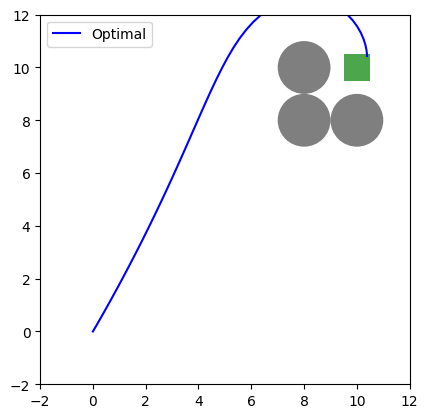

In [109]:
plot_1_traj(xs_optimal, obs_set, target_high, label='Optimal', linemap = 'b')

In [110]:
# Bad Running and Terminal Model
# w_run = np.array([10, 1., 1., 0., 0., 0.])
# w_term = np.array([1000, 1., 1., 0., 0., 0.])
w_run = np.array([0, 0., 0., 0., 0., 0.])
w_term = np.array([0, 0., 0., 0., 0., 0.])
w_bad = np.hstack([w_run, w_term])
# w_bad = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_bad = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()
w_run = w_bad[:nr]; w_term = w_bad[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_non_opt = mim_solvers.SolverSQP(problem)
sqp_non_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_non_opt.with_callbacks=True
sqp_non_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_non_opt.solve(xs_init, us_init, 500)
xs_non_optimal = np.stack(sqp_non_opt.xs.tolist().copy())
us_non_optimal = np.stack(sqp_non_opt.us.tolist().copy())
print(done)


iter     merit         cost         grad      step    ||gaps||        KKT
 END  0.00000e+00  0.00000e+00  0.00000e+00   ----   0.00000e+00  0.00000e+00
True


In [111]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())

In [112]:
# plot_1_traj(xs_non_optimal, obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [113]:
print('Desired Trajectory Cost:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep), ' || other Trajectory, same cost:   ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_des[:nr], w_des[nr:], timeStep))
print('Bad Trajectory Cost:      ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_bad[:nr], w_bad[nr:], timeStep), ' || other Trajectory, same cost:   ', cost_set.traj_cost(xs_optimal, us_optimal, w_bad[:nr], w_bad[nr:], timeStep))

Desired Trajectory Cost:   1.4880389633500672  || other Trajectory, same cost:    101.25000000000001
Bad Trajectory Cost:       0.0  || other Trajectory, same cost:    0.0


In [114]:
###### IRL #######

In [115]:
# generating bad trajectories
num_bad = 10
scales = 1
xs_non_optimal_set = []
us_non_optimal_set = []
xs_non_optimal_set.append(np.stack(xs_non_optimal.tolist()).copy())
us_non_optimal_set.append(np.stack(us_non_optimal.tolist()).copy())
for _ in range(num_bad):
    # # Get one non-optimal sample from non-optimal demo
    Us = us_non_optimal.copy()+np.random.normal(0,scales,np.stack(us_non_optimal.tolist()).shape)
    us_non_optimal_set.append(Us)
    xs_non_optimal_set.append(np.stack(problem.rollout([Us[i] for i in range(T)])))
    # # Get one non-optimal sample from optimal demo
    Us = us_optimal.copy()+np.random.normal(0,scales,np.stack(us_non_optimal.tolist()).shape)
    us_non_optimal_set.append(Us)
    xs_non_optimal_set.append(np.stack(problem.rollout([Us[i] for i in range(T)])))

In [116]:
opt_cost = np.exp(-cost_set.traj_cost(xs_optimal,us_optimal,w_des[:nr], w_des[nr:], timeStep))
print(opt_cost)
for X, U in zip(xs_non_optimal_set, us_non_optimal_set):
    print('Modified: ', np.exp(-cost_set.traj_cost(X,U,w_bad[:nr], w_bad[nr:], timeStep))/opt_cost, 
         'Original: ', np.exp(-cost_set.traj_cost(X,U,w_bad[:nr], w_bad[nr:], timeStep)))

0.22581505321409506
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0
Modified:  4.428402738288225 Original:  1.0


In [117]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    # x /= np.linalg.norm(x)
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        den += np.exp(-cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_nSamples(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, samples, Lambda = 0.001):
    nr = cost_set.nr
    num_samples = samples # Have these number of samples per trajectory equidistantly starting from the beginning
    output = 0
    for i in np.int32(np.linspace(0, len(xs_optimal), num=num_samples+1))[:-1]:
        num = np.nextafter(0,1)
        den = np.nextafter(0,1)
        X_opt = xs_optimal[i:].copy(); U_opt = us_optimal[i:].copy()
        num += np.exp(-cost_set.traj_cost(X_opt, U_opt, x[:nr], x[nr:], dt))
        den += num
        for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
            X_nopt = Xs[i:].copy(); U_nopt = Us[i:].copy()
            den += np.max([np.nextafter(0,1), np.exp(-cost_set.traj_cost(X_nopt, U_nopt, x[:nr], x[nr:], dt))])
        output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_cum(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    return True

# def fcn_w_nD(x, cost_set, xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
#     # x /= np.linalg.norm(x)
#     nr = cost_set.nr
#     output = 0
#     for Xs_opt, Us_opt in zip(xs_optimal_set, us_optimal_set):
#         num = np.nextafter(0,1)
#         den = np.nextafter(0,1)
#         num += np.exp(-cost_set.traj_cost(Xs_opt, Us_opt, x[:nr], x[nr:], dt))
#         den += num
#         for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
#             den += np.exp(-cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt))
#         output -= np.log(num/den)
    
#     output += Lambda*np.linalg.norm(x)
#     return output



In [152]:
dt = timeStep
Lambda = 0.0001
lb = 0.0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 100, 'iprint': 1,'ftol': 1e-15 ,'gtol' : 1e-15}
tol = 1e-15
samples = 1
# w0 = w_bad
w0 = np.zeros_like(w_bad)
# w0 = w_des
# w0 = 10*np.ones_like(w_bad)

# 1 Optimal Demo
# args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda)
# res = minimize(fcn_w, 
#                w0, 
#                args, 
#                bounds=bnds, 
#                method='L-BFGS-B', 
#                tol = tol,
#                options=options)
# print(res)

# 1 Optimal Demo, Multiple Samples
args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, samples, Lambda)
res = minimize(fcn_w_nSamples, 
               w0, 
               args, 
               bounds=bnds, 
               method='L-BFGS-B', 
               tol = tol,
               options=options)
print(res)


# WIRL = []
# for i in range(1,len(xs_non_optimal_set)):
#     xs_no_subset = xs_non_optimal_set[:i]
#     us_no_subset = us_non_optimal_set[:i]
#     res = minimize(fcn_w, 
#                    w0, 
#                    args=(cost_set, xs_optimal, us_optimal, xs_no_subset, us_no_subset, dt, Lambda), 
#                    bounds=bnds, 
#                    method='L-BFGS-B', 
#                    tol = tol,
#                    options=options)
#     WIRL.append(res.x)
#     print(res)

w_irl = res.x

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0        12 variables are exactly at the bounds

At iterate    0    f=  3.09104D+00    |proj g|=  5.02897D+01

At iterate    1    f=  2.54386D+00    |proj g|=  4.71547D-01

At iterate    2    f=  2.50705D+00    |proj g|=  4.36853D-01

At iterate    3    f=  2.36523D+00    |proj g|=  3.92052D-01

At iterate    4    f=  2.36350D+00    |proj g|=  3.99125D-01

At iterate    5    f=  2.35795D+00    |proj g|=  4.65719D-01

At iterate    6    f=  2.34133D+00    |proj g|=  5.39800D-01

At iterate    7    f=  2.02774D+00    |proj g|=  2.72799D-01

At iterate    8    f=  1.53855D+00    |proj g|=  1.69852D-01

At iterate    9    f=  1.02055D+00    |proj g|=  9.74961D-02

At iterate   10    f=  5.06690D-01    |proj g|=  6.53104D-02

At iterate   11    f=  2.42915D-01    |proj g|=  3.99054D-02

At iterate   12    f=  1.22803D-01    |proj g|=  2.26098D-02

At iterate   13    f=  6.2


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   72    f=  4.80070D-03    |proj g|=  2.70617D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     72    104     73     0     5   2.706D-08   4.801D-03
  F =   4.8007034841359335E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [153]:
# w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.005 IRL:  0.0
Terminal ||  Desired:  1.0 IRL:  35.108653582335194

XReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  0.0

UReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  0.0

Obs1 :
Running ||  Desired:  0.5 IRL:  1.8787582530839073
Terminal ||  Desired:  0.5 IRL:  10.74242022616058

Obs2 :
Running ||  Desired:  0.5 IRL:  13.018388985133166
Terminal ||  Desired:  0.5 IRL:  18.56850492364502

Obs3 :
Running ||  Desired:  0.5 IRL:  0.014487508154801643
Terminal ||  Desired:  0.5 IRL:  0.3664943242432211



In [154]:
# w_irl = w_irl/np.max(w_irl)

In [155]:
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep), ' || with IRL Weight:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
print('Bad Trajectory Cost:     ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_bad[:nr], w_bad[nr:], timeStep), ' || with IRL Weight:  ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_irl[:nr], w_irl[nr:], timeStep))

Desired Trajectory Cost:  1.4880389633500672  || with IRL Weight:   11.995622183867216
Bad Trajectory Cost:      0.0  || with IRL Weight:   3510.86535823352


In [156]:
# Test IRL Output
print('Desired Fcn:    ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('IRL Fcn:        ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('Bad Fcn:        ', fcn_w(w_bad, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))

Desired Fcn:     1.9240769593117941
IRL Fcn:         0.0048007034841359335
Bad Fcn:         3.0910424533583156


In [157]:
# Test IRL multiSample Output
print('Desired Fcn:    ', fcn_w_nSamples(w_des, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, samples, Lambda))
print('IRL Fcn:        ', fcn_w_nSamples(w_irl, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, samples, Lambda))
print('Bad Fcn:        ', fcn_w_nSamples(w_bad, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, samples, Lambda))

Desired Fcn:     1.9240769593117941
IRL Fcn:         0.0048007034841359335
Bad Fcn:         3.0910424533583156


In [180]:
# Run again with bad weights (zero for obstacles)
w_run = w_irl[:nr]
w_term = w_irl[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
# x0 = np.array([5.0, 5.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp = mim_solvers.SolverSQP(problem)
sqp.setCallbacks([crocoddyl.CallbackVerbose()])
sqp.with_callbacks=True
sqp.termination_tolerance = 1e-5
# xs_init = [x0 for i in range(T+1)]
# us_init = [u0 for i in range(T)]
xs_init = [xs_optimal[i] for i in range(T+1)]
us_init = [us_optimal[i] for i in range(T)]

# Solving this problem
done = sqp.solve(xs_init, us_init, 500)
xs_output = np.stack(sqp.xs.tolist().copy())
us_output = np.stack(sqp.us.tolist().copy())

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.19956e+01  1.19956e+01  8.02676e+00  1.0000  3.29212e-10  7.21150e+00
   2  1.02947e+01  1.02947e+01  3.00259e+00  1.0000  1.60404e-08  1.08803e+00
   3  1.03158e+01  1.03158e+01  1.27482e+00  1.0000  5.87849e-09  1.58159e-01
   4  1.01377e+01  1.01377e+01  2.14966e+00  1.0000  2.56489e-09  1.82761e-01
   5  1.00842e+01  1.00842e+01  1.46285e+00  1.0000  6.83897e-09  8.48199e-02
   6  1.00590e+01  1.00590e+01  4.85242e+00  1.0000  2.92175e-09  2.08859e-01
   7  1.00093e+01  1.00093e+01  8.40675e-01  1.0000  8.50595e-09  8.75568e-03
   8  1.00059e+01  1.00059e+01  6.91324e-01  1.0000  2.19968e-09  8.76033e-03
   9  1.00028e+01  1.00028e+01  4.76455e+00  1.0000  1.57545e-09  5.85927e-02
  10  9.98528e+00  9.98528e+00  5.52447e+00  0.5000  1.22887e-08  1.09801e-01
iter     merit         cost         grad      step    ||gaps||        KKT
  11  1.00216e+01  1.00216e+01  6.57384e-01  1.0000  1.10418e-08  8.7139

In [181]:
print('IRL Trajectory Cost:  ', cost_set.traj_cost(xs_output, us_output, w_irl[:nr], w_irl[nr:], timeStep))
print('with Desired Weight:  ', cost_set.traj_cost(xs_output, us_output, w_des[:nr], w_des[nr:], timeStep)) 
print('with Bad Weight:      ', cost_set.traj_cost(xs_output, us_output, w_bad[:nr], w_bad[nr:], timeStep))

IRL Trajectory Cost:   9.96617527666545
with Desired Weight:   2.9790877696186766
with Bad Weight:       0.0


In [182]:
print('IRL Trajectory Cost:      ', cost_set.traj_cost(xs_output, us_output, w_irl[:nr], w_irl[nr:], timeStep))
print('Desired Trajectory Cost:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))

IRL Trajectory Cost:       9.96617527666545
Desired Trajectory Cost:   1.4880389633500672


In [183]:
print('IRL Trajectory with Desired Cost: ', cost_set.traj_cost(xs_output, us_output, w_des[:nr], w_des[nr:], timeStep))
print('Initial Optimal Trajectory Cost:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))

IRL Trajectory with Desired Cost:  2.9790877696186766
Initial Optimal Trajectory Cost:   1.4880389633500672


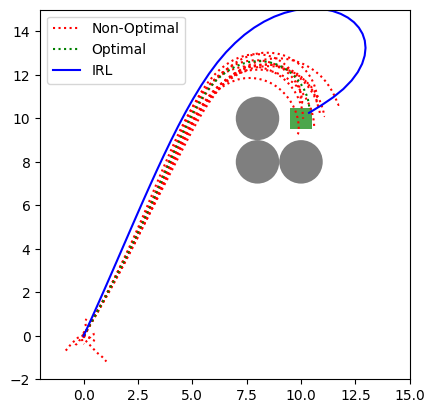

In [184]:
plot_results(xs_optimal, xs_non_optimal_set, xs_output, obs_set, target_high)

In [185]:
# creating sets
all_set_x = []
all_set_u = []
training_set_x = []
training_set_u = []

all_set_x.append(xs_output); all_set_x.append(xs_optimal); training_set_x.append(xs_optimal)
all_set_u.append(us_output); all_set_u.append(us_optimal); training_set_u.append(us_optimal)

for X, U in zip(xs_non_optimal_set, us_non_optimal_set):
    all_set_x.append(X); training_set_x.append(X)
    all_set_u.append(U); training_set_u.append(U)

In [186]:
P_irl = distributions(cost_set, training_set_x, training_set_u, w_irl[:nr], w_irl[nr:], dt)
P_des = distributions(cost_set, training_set_x, training_set_u, w_des[:nr], w_des[nr:], dt)
P_comp = distributions(cost_set, all_set_x, all_set_u, w_irl[:nr], w_irl[nr:], dt)  

In [187]:
P_comp/np.max(P_comp)

array([1.00000000e+00, 1.31408182e-01, 0.00000000e+00, 0.00000000e+00,
       1.41284326e-05, 0.00000000e+00, 4.98168292e-09, 0.00000000e+00,
       2.49084497e-05, 0.00000000e+00, 5.46815516e-06, 0.00000000e+00,
       2.59626467e-20, 0.00000000e+00, 1.75621036e-05, 0.00000000e+00,
       7.78194437e-09, 0.00000000e+00, 1.14113013e-06, 0.00000000e+00,
       9.39961964e-28, 0.00000000e+00, 6.76719378e-09])

In [188]:
P_irl/np.max(P_irl)

array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.07515624e-04,
       0.00000000e+00, 3.79099904e-08, 0.00000000e+00, 1.89550220e-04,
       0.00000000e+00, 4.16119839e-05, 0.00000000e+00, 1.97572528e-19,
       0.00000000e+00, 1.33645435e-04, 0.00000000e+00, 5.92196334e-08,
       0.00000000e+00, 8.68385906e-06, 0.00000000e+00, 7.15299421e-27,
       0.00000000e+00, 5.14975071e-08])

In [189]:
P_des/np.max(P_des)

array([1.00000000e+00, 4.71987849e-44, 1.07900929e-45, 7.81876051e-01,
       1.43232619e-40, 5.96420716e-01, 1.79567326e-41, 8.15648977e-01,
       2.58887865e-51, 7.22912687e-01, 1.08067371e-43, 1.72355206e-01,
       8.06978450e-43, 7.03633720e-01, 1.92231467e-45, 5.13782848e-01,
       2.99910712e-40, 7.39797104e-01, 1.03842447e-42, 1.76873793e-01,
       4.66476907e-48, 6.24440088e-01])

/tmp/ipykernel_22457/1964157370.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(-1/np.log(P_irl[1:]),label='IRL')
/tmp/ipykernel_22457/1964157370.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(-1/np.log(P_comp[2:]),label='w/ IRL output')


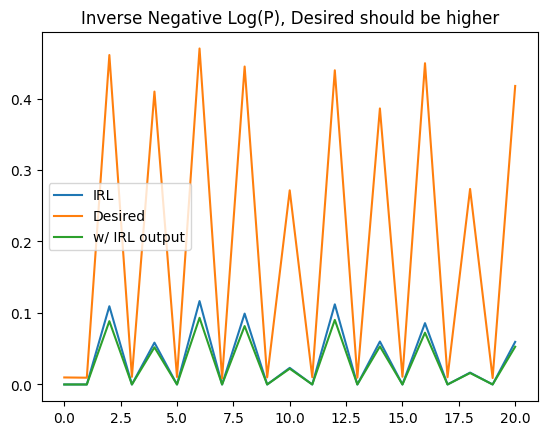

In [190]:
plt.plot(-1/np.log(P_irl[1:]),label='IRL')
plt.plot(-1/np.log(P_des[1:]),label='Desired')
plt.plot(-1/np.log(P_comp[2:]),label='w/ IRL output')
plt.legend()
plt.title('Inverse Negative Log(P), Desired should be higher')
plt.show()